<a href="https://colab.research.google.com/github/ifankang/AIGen_YouTube_Transcript_Comments_Analysis/blob/main/Capstone_Project_Ifan_Kang_Youtube_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# @markdown This notebook demonstrates how to leverage IBM Large Language Models (LLMs) to automate daily tasks, specifically focusing on summarizing and classifying YouTube comments.

# @markdown **How to use this notebook:**
# @markdown 1. **Connect to Google Drive:** Doesnt need to ensure your Google Drive is mounted or not to this notbook won't save files.
# @markdown 2. **Install necessary libraries:** Run the cells to install required packages.
# @markdown 3. **Configure API Keys:** Set your Replicate API Token and Google API Key in Colab Secrets (`REPLICATE_API_TOKEN` and `YOUTUBE_API_KEY`).
# @markdown 4. **Enter YouTube Video URL:** Provide the URL of the YouTube video you want to analyze in the "Run Analysis" section.
# @markdown 5. **Adjust Advanced Settings (Optional):** Customize parameters like preferred languages, maximum comments to fetch, LLM chunk size, and the number of comment clusters.
# @markdown 6. **Run the Analysis:** Execute the cell in the "Run Analysis" section.
# @markdown 7. **Review Results:** Examine the generated summary, sentiment analysis, and comment cluster insights.

# @markdown **What can be customized:**
# @markdown * **YouTube Video URL:** Analyze different videos by changing the URL.
# @markdown * **Preferred Languages:** Specify the order of preferred languages for transcript fetching.
# @markdown * **Maximum Comments to Fetch:** Control the number of comments retrieved for analysis.
# @markdown * **LLM Chunk Size:** Adjust the size of text chunks processed by the LLM, which can impact performance and the level of detail in the summary.
# @markdown * **Number of Comment Clusters:** Change the number of groups comments are categorized into during clustering.
# @markdown * **Prompt Templates:** The prompt templates for topic extraction and sentiment analysis (`topic_extraction_prompt` and `sentiment_analysis_prompt_template`) can be modified to alter the LLM's output and focus.
# @markdown * **IBM LLM Model:** The specific IBM Granite model used can be changed in the `ReplicateLLMHandler` class constructor.
# @markdown * **Preprocessing Steps:** The `TextPreprocessor` class can be modified to include or exclude preprocessing steps like stemming or adding/removing stopwords for other languages.

# @markdown This notebook is made by **Ifan_Kang** (and Gemini.AI) brought to you by the **Hacktive8 Bootcamp X IBM** partnership.
#@title Youtube Analysis
# Mount Google Drive
drive.mount('/content/drive')
# =====================
# @title 📦 Install Libraries
# =====================
!pip install youtube-transcript-api google-api-python-client nltk Sastrawi emoji -q langchain_community replicate

# =====================
# 📚 Imports
# =====================
# from replicate.client import Client

# =====================
# @title 🔗 YouTube Data Fetcher
# =====================
class YouTubeDataFetcher:
    def get_youtube_transcript(self, video_id, languages):
        try:
            transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=languages)
            return transcript
        except Exception as e:
            print(f"Transcript error for video ID {video_id}: {e}")
            return None

    def get_youtube_comments(self, video_id, api_key, max_comments=300):
        try:
            youtube = build('youtube', 'v3', developerKey=api_key)
            comments = []
            next_page_token = None

            while len(comments) < max_comments:
                response = youtube.commentThreads().list(
                    part='snippet',
                    videoId=video_id,
                    maxResults=100,
                    pageToken=next_page_token
                ).execute()

                for item in response['items']:
                    comment = item['snippet']['topLevelComment']['snippet']
                    comments.append({
                        'author': comment['authorDisplayName'],
                        'text': comment['textDisplay'],
                        'published_at': comment['publishedAt']
                    })

                next_page_token = response.get('nextPageToken')
                if not next_page_token:
                    break

            return comments[:max_comments]

        except Exception as e:
            print(f"Comments error for video ID {video_id}: {e}")
            return None

    def detect_best_language(self, video_id, preferred_order=['id', 'en']):
        try:
            transcripts = YouTubeTranscriptApi.list_transcripts(video_id)
            available_languages = [t.language_code for t in transcripts]

            print(f"Available transcript languages: {available_languages}")

            for lang in preferred_order:
                if lang in available_languages:
                    print(f"Selected language: {lang}")
                    return lang

            if available_languages:
                fallback = available_languages[0]
                print(f"Fallback language: {fallback}")
                return fallback

            print("No transcript available.")
            return None

        except Exception as e:
            print(f"Language detection error for video ID {video_id}: {e}")
            return None
# =====================
# @title 🧹 Preprocessor
# =====================
class TextPreprocessor:
    def __init__(self):
        for resource in ['punkt', 'stopwords']:
            try:
                nltk.data.find(f'tokenizers/{resource}')
            except LookupError:
                nltk.download(resource)

    def preprocess_text(self, text, language='english'):
        if not text:
            return ""

        text = text.lower()
        text = re.sub(r'http\S+|www\S+', '', text)
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        tokens = text.split()  # Faster than nltk tokenization

        try:
            stop_words = set(stopwords.words(language))
            tokens = [word for word in tokens if word not in stop_words]
        except:
            print(f"No stopwords found for language code: {language}")

        if language == 'indonesian':
            factory = StemmerFactory()
            stemmer = factory.create_stemmer()
            tokens = [stemmer.stem(word) for word in tokens]

        return ' '.join(tokens)
# =====================
# @title 🧠 LLM Handler
# =====================
class ReplicateLLMHandler:
    def __init__(self, model_name="ibm-granite/granite-3.3-8b-instruct"):
        self._api_token = userdata.get('REPLICATE_API_TOKEN')
        if not self._api_token:
            raise ValueError("Replicate API Token not found in Colab Secrets. Please add it with key 'REPLICATE_API_TOKEN'.")
        os.environ["REPLICATE_API_TOKEN"] = self._api_token
        self._model_name = model_name
        self._llm = self._initialize_model()

    def _initialize_model(self):
        return Replicate(
            model=self._model_name,
            replicate_api_token=self._api_token
        )

    def invoke_model(self, prompt):
        parameters = {
        #     "top_k": 3,
        #     "top_p": 0.9,
            "max_tokens": 50000  # Increased max_tokens for potentially longer responses
        #     "min_tokens": 0,
        #     "random_seed": None,
        #     "repetition_penalty": 1.5,
        #     "stopping_sequence": None # Changed stopping_sequence to None
        }
        return self._llm.invoke(prompt, parameters=parameters) # Pass parameters as keyword arguments




# =====================
# 🔥 Sentiment Analyzer
# =====================
class SentimentAnalyzer:
    def __init__(self, ai_model):
        self.ai_model = ai_model

    def analyze(self, text, topic_prompt, sentiment_prompt):
        # print("debbug : "+topic_prompt + text)
        topic_query = topic_prompt + text
        topics = self.ai_model.invoke_model(topic_query)

        sentiment_query = sentiment_prompt.format(topic=topics) + text
        sentiment_result = self.ai_model.invoke_model(sentiment_query)

        return sentiment_result
# =====================
# @title 🪓 Chunk Utility
# =====================
def chunk_text(text, chunk_size=500):
    words = text.split()
    for i in range(0, len(words), chunk_size):
        yield ' '.join(words[i:i + chunk_size])

# =====================
# @title 📄 Prompt Templates
# =====================
topic_extraction_prompt = """
Buat rangkuman topik dari teks berikut dalam format lengkap HTML dan menggunakan hirarki tipografi, fokus di key point dan insight:
Teks:
"""

sentiment_analysis_prompt_template = """
Tampilkan dalam format lengkap HTML dan menggunakan hirarki tipografi
Analisis sentimen untuk topik berikut: {topic}
Simpulkan dan berikan actionable insight
Validasi dengan keritis
rekomendasi strategis
Gunakan bahasa Indonesia yang natural dan casual.
Teks:
"""
# =====================
# @title 🎨 Beautify Output Function
# =====================
def beautify_output(html_content):
    css = """
    <style>
      h2 {color:#1a237e; border-bottom:2px solid #7986cb; padding-bottom:4px;}
      h3 {color:#3949ab; margin-top:10px;}
      p, li {font-size:15px; color:#212121; line-height:1.6;}
      ul {padding-left:20px;}
      span {font-weight:bold;}
    </style>
    """
    return css + html_content
# =====================
# @title 🔢 Vectorization
# =====================

class Vectorizer:
    def __init__(self, max_features=10000):
        self.vectorizer = TfidfVectorizer(max_features=max_features)

    def fit(self, corpus):
        self.vectorizer.fit(corpus)

    def transform(self, corpus):
        return self.vectorizer.transform(corpus)

    def fit_transform(self, corpus):
        return self.vectorizer.fit_transform(corpus)

    def get_feature_names(self):
        return self.vectorizer.get_feature_names_out()
# =====================
# @title 📊 Clustering
# =====================

class TextClusterer:
    def __init__(self, n_clusters=5):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

    def fit_predict(self, vectorized_text):
        return self.kmeans.fit_predict(vectorized_text)

    def get_cluster_centers(self):
        return self.kmeans.cluster_centers_

    def visualize_clusters(self, vectorized_text, labels):
        # Use PCA for dimensionality reduction to 2 components for visualization
        if vectorized_text.shape[1] > 2:
            pca = PCA(n_components=2)
            reduced_text = pca.fit_transform(vectorized_text.toarray())
        else:
            reduced_text = vectorized_text.toarray()

        plt.figure(figsize=(10, 7))
        sns.scatterplot(x=reduced_text[:, 0], y=reduced_text[:, 1], hue=labels, palette='viridis', legend='full')
        plt.title('Text Clusters (PCA Reduction)')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.show()

# =====================
# @title 🚀 Main Function
# =====================
def summarize_youtube_data(video_url, api_key, languages=['id', 'en'], max_comments=300, chunk_size=500, num_clusters=5):
    """
    Fetches YouTube comments and transcript, preprocesses them,
    summarizes them using an LLM, clusters comments, and analyzes sentiment.

    Args:
        video_url (str): The URL of the YouTube video.
        api_key (str): Your Google API key.
        languages (list): Preferred languages for transcript.
        max_comments (int): Maximum number of comments to fetch.
        chunk_size (int): Size of text chunks for LLM processing.
        num_clusters (int): Number of clusters for comment analysis.
    """
    # Extract video ID from URL
    video_id_match = re.search(r'(?<=v=)[a-zA-Z0-9_-]+', video_url)
    if not video_id_match:
        print("Invalid YouTube URL.")
        return

    video_id = video_id_match.group(0)
    print(f"Processing video ID: {video_id}")

    fetcher = YouTubeDataFetcher()
    preprocessor = TextPreprocessor()
    llm_handler = ReplicateLLMHandler()
    sentiment_analyzer = SentimentAnalyzer(llm_handler)
    vectorizer = Vectorizer()
    clusterer = TextClusterer(n_clusters=num_clusters)

    # 1. Fetch Data
    best_lang = fetcher.detect_best_language(video_id, preferred_order=languages)
    transcript_text = ""
    if best_lang:
        transcript = fetcher.get_youtube_transcript(video_id, languages=[best_lang])
        if transcript:
            transcript_text = " ".join([item['text'] for item in transcript])
            print(f"Fetched transcript in {best_lang}.")
        else:
            print("Failed to fetch transcript.")
    else:
        print("No suitable transcript found.")


    comments = fetcher.get_youtube_comments(video_id, api_key, max_comments)
    if not comments:
        print("Failed to fetch comments.")
        comments = [] # Ensure comments is an empty list if fetching fails

    print(f"Fetched {len(comments)} comments.")

    # 2. Preprocess Data
    preprocessed_transcript = preprocessor.preprocess_text(transcript_text, language=best_lang if best_lang else 'english')
    comment_texts = [comment['text'] for comment in comments]

    # Use ThreadPoolExecutor for faster comment preprocessing
    preprocessed_comments = []
    with ThreadPoolExecutor(max_workers=5) as executor:
        # Determine comment language - simple approach: assume English if transcript isn't available
        comment_lang = best_lang if best_lang else 'english'
        results = executor.map(lambda text: preprocessor.preprocess_text(text, language=comment_lang), comment_texts)
        preprocessed_comments = list(results)

    # Remove empty strings after preprocessing
    preprocessed_comments = [comment for comment in preprocessed_comments if comment.strip()]

    print(f"Preprocessing complete. {len(preprocessed_comments)} comments remain after cleaning.")

    # Combine transcript and comments for overall summary (optional)
    all_text = preprocessed_transcript + " " + " ".join(preprocessed_comments)

    # 3. Summarize using LLM (using all text or just comments)
    print("Generating summary and sentiment analysis...")

    if not all_text.strip():
        print("No text available to summarize.")
        summary_html = beautify_output("<h2>Summary</h2><p>No content to summarize.</p>")
        sentiment_html = beautify_output("<h2>Sentiment Analysis</h2><p>No content to analyze.</p>")
    else:
        # Chunk text for LLM processing if it's too long
        text_chunks = list(chunk_text(all_text, chunk_size=chunk_size))

        # Summarize each chunk (can be parallelized if needed)
        chunk_summaries = []
        for i, chunk in enumerate(text_chunks):
            print(f"Processing chunk {i+1}/{len(text_chunks)}...")
            try:
                chunk_summary_prompt = topic_extraction_prompt + chunk
                chunk_summary = llm_handler.invoke_model(chunk_summary_prompt)
                chunk_summaries.append(chunk_summary)
                # print(f"Chunk {i+1} summary: {chunk_summary[:200]}...") # Debug print
            except Exception as e:
                 print(f"Error summarizing chunk {i+1}: {e}")
                 chunk_summaries.append("")

        # Combine chunk summaries for overall summary/topics
        overall_topics = " ".join(chunk_summaries)

        # Generate overall summary based on overall_topics and format as HTML
        if overall_topics.strip():
            summary_html = beautify_output(f"<h2>Summary</h2><p>{overall_topics}</p>")
        else:
            summary_html = beautify_output("<h2>Summary</h2><p>Could not generate a summary from the text.</p>")


        # Perform sentiment analysis on the combined topics and potentially the relevant text
        # For simplicity, we'll analyze sentiment based on the overall topics derived
        # A more advanced approach would involve analyzing sentiment per comment or based on the full text
        try:
            sentiment_analysis_result = sentiment_analyzer.analyze(
                text=" ".join(preprocessed_comments), # Analyze sentiment based on preprocessed comments
                topic_prompt=topic_extraction_prompt, # Use topic extraction prompt for initial topic identification by analyzer
                sentiment_prompt=sentiment_analysis_prompt_template
            )
            sentiment_html = beautify_output(sentiment_analysis_result)
            print("Sentiment analysis complete.")
        except Exception as e:
            print(f"Error during sentiment analysis: {e}")
            sentiment_html = beautify_output("<h2>Sentiment Analysis</h2><p>Error performing sentiment analysis.</p>")


    # 4. Cluster Comments (using preprocessed comments)
    print("Clustering comments...")
    comment_texts_for_clustering = [comment['text'] for comment in comments if preprocessor.preprocess_text(comment['text'], language=best_lang if best_lang else 'english').strip()]

    if comment_texts_for_clustering:
        try:
            vectorized_comments = vectorizer.fit_transform(comment_texts_for_clustering)
            comment_labels = clusterer.fit_predict(vectorized_comments)

            print(f"Clustering complete. Found {num_clusters} clusters.")

            # Optionally visualize clusters
            try:
                 clusterer.visualize_clusters(vectorized_comments, comment_labels)
            except Exception as e:
                 print(f"Error visualizing clusters: {e}")


            # Display example comments from each cluster
            cluster_summary_html = "<h2>Comment Clusters</h2>"
            for i in range(num_clusters):
                cluster_indices = [j for j, label in enumerate(comment_labels) if label == i]
                if cluster_indices:
                    cluster_summary_html += f"<h3>Cluster {i+1} ({len(cluster_indices)} comments)</h3>"
                    # Get indices relative to original comments list
                    original_indices = [idx for idx, preprocessed_comment in enumerate([preprocessor.preprocess_text(c['text'], language=best_lang if best_lang else 'english') for c in comments]) if preprocessed_comment.strip() and preprocessed_comment.strip() in comment_texts_for_clustering][cluster_indices[0]:cluster_indices[0]+3] # Show first 3 from original list

                    cluster_summary_html += "<ul>"
                    for original_idx in original_indices:
                         if original_idx < len(comments):
                            cluster_summary_html += f"<li>... {comments[original_idx]['text'][:150]} ...</li>" # Show snippet of original comment
                    cluster_summary_html += "</ul>"
                else:
                     cluster_summary_html += f"<h3>Cluster {i+1} (0 comments)</h3><p>No comments in this cluster.</p>"

            cluster_html = beautify_output(cluster_summary_html)

        except Exception as e:
            print(f"Error during comment clustering: {e}")
            cluster_html = beautify_output("<h2>Comment Clusters</h2><p>Error performing comment clustering.</p>")

    else:
         print("Not enough valid comments for clustering.")
         cluster_html = beautify_output("<h2>Comment Clusters</h2><p>Not enough valid comments for clustering.</p>")


    # 5. Display Results
    display(HTML(summary_html)) # Display summary HTML
    display(HTML(sentiment_html))
    display(HTML(cluster_html))


# =====================
# @title ▶️ Run Analysis
# =====================

# @markdown Enter the YouTube video URL and your Google API Key
youtube_video_url = "https://www.youtube.com/watch?v=oX7OduG1YmI" #@param {type:"string"}
youtube_api_key_name= "YOUTUBE_API_KEY" # @param {type:"string"}
google_api_key = youtube_api_key_name

# @markdown Advanced Settings
preferred_languages = "id,en" # @param {type:"string"}
max_comments_to_fetch = 3000 # @param {type:"number"}
llm_chunk_size = 500 # @param {type:"number"}
number_of_comment_clusters = 5 # @param {type:"number"}

# Split preferred languages string into a list
preferred_languages_list = [lang.strip() for lang in preferred_languages.split(',') if lang.strip()]

if not youtube_video_url or youtube_video_url == "https://www.youtube.com/watch?v=example_video_id":
    print("Please enter a valid YouTube video URL.")
elif not google_api_key:
     print("Please set your Google API Key in Colab Secrets (key name: YOUTUBE_API_KEY).")
else:
    summarize_youtube_data(
        youtube_video_url,
        google_api_key,
        languages=preferred_languages_list,
        max_comments=max_comments_to_fetch,
        chunk_size=llm_chunk_size,
        num_clusters=number_of_comment_clusters
    )


In [ ]:
# =====================
# @title 📦 Install Libraries
# =====================
!pip install youtube-transcript-api google-api-python-client nltk Sastrawi emoji -q langchain_community replicate

# =====================
# 📚 Imports
# =====================
from youtube_transcript_api import YouTubeTranscriptApi
from googleapiclient.discovery import build
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from IPython.display import display, HTML
from google.colab import userdata
from langchain_community.llms import Replicate
# from replicate.client import Client
import os
from concurrent.futures import ThreadPoolExecutor


In [ ]:
# =====================
# @title 🔗 YouTube Data Fetcher
# =====================
class YouTubeDataFetcher:
    def get_youtube_transcript(self, video_id, languages):
        try:
            transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=languages)
            return transcript
        except Exception as e:
            print(f"Transcript error {video_id}: {e}")
            return None

    def get_youtube_comments(self, video_id, api_key, max_comments=300):
        try:
            youtube = build('youtube', 'v3', developerKey=api_key)
            comments = []
            next_page_token = None

            while len(comments) < max_comments:
                response = youtube.commentThreads().list(
                    part='snippet',
                    videoId=video_id,
                    maxResults=100,
                    pageToken=next_page_token
                ).execute()

                for item in response['items']:
                    comment = item['snippet']['topLevelComment']['snippet']
                    comments.append({
                        'author': comment['authorDisplayName'],
                        'text': comment['textDisplay'],
                        'published_at': comment['publishedAt']
                    })

                next_page_token = response.get('nextPageToken')
                if not next_page_token:
                    break

            return comments[:max_comments]

        except Exception as e:
            print(f"Comments error {video_id}: {e}")
            return None

    def detect_best_language(self, video_id, preferred_order=['id', 'en']):
        try:
            transcripts = YouTubeTranscriptApi.list_transcripts(video_id)
            available_languages = [t.language_code for t in transcripts]

            print(f"Available transcript languages: {available_languages}")

            for lang in preferred_order:
                if lang in available_languages:
                    print(f"Selected language: {lang}")
                    return lang

            if available_languages:
                fallback = available_languages[0]
                print(f"Fallback language: {fallback}")
                return fallback

            print("No transcript available.")
            return None

        except Exception as e:
            print(f"Language detection error {video_id}: {e}")
            return None

In [ ]:
# =====================
# @title 🧹 Preprocessor
# =====================
class TextPreprocessor:
    def __init__(self):
        for resource in ['punkt', 'stopwords']:
            try:
                nltk.data.find(f'tokenizers/{resource}')
            except LookupError:
                nltk.download(resource)

    def preprocess_text(self, text, language='english'):
        if not text:
            return ""

        text = text.lower()
        text = re.sub(r'http\S+|www\S+', '', text)
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        tokens = text.split()  # Faster than nltk tokenization

        try:
            stop_words = set(stopwords.words(language))
            tokens = [word for word in tokens if word not in stop_words]
        except:
            print(f"No stopwords for {language}")

        if language == 'indonesian':
            factory = StemmerFactory()
            stemmer = factory.create_stemmer()
            tokens = [stemmer.stem(word) for word in tokens]

        return ' '.join(tokens)

In [ ]:
# =====================
# @title 🧠 LLM Handler
# =====================
class ReplicateLLMHandler:
    def __init__(self, model_name="ibm-granite/granite-3.3-8b-instruct"):
        self._api_token = userdata.get('api_token')
        os.environ["REPLICATE_API_TOKEN"] = self._api_token
        self._model_name = model_name
        self._llm = self._initialize_model()

    def _initialize_model(self):
        return Replicate(
            model=self._model_name,
            replicate_api_token=self._api_token
        )

    def invoke_model(self, prompt):
        parameters = {
        #     "top_k": 3,
        #     "top_p": 0.9,
            "max_tokens": 50000  # Increased max_tokens for potentially longer responses
        #     "min_tokens": 0,
        #     "random_seed": None,
        #     "repetition_penalty": 1.5,
        #     "stopping_sequence": None # Changed stopping_sequence to None
        }
        return self._llm.invoke(prompt, parameters=parameters) # Pass parameters as keyword arguments




# =====================
# 🔥 Sentiment Analyzer
# =====================
class SentimentAnalyzer:
    def __init__(self, ai_model):
        self.ai_model = ai_model

    def analyze(self, text, topic_prompt, sentiment_prompt):
        # print("debbug : "+topic_prompt + text)
        topic_query = topic_prompt + text
        topics = self.ai_model.invoke_model(topic_query)

        sentiment_query = sentiment_prompt.format(topic=topics) + text
        sentiment_result = self.ai_model.invoke_model(sentiment_query)

        return sentiment_result

In [ ]:
# =====================
# @title 🪓 Chunk Utility
# =====================
def chunk_text(text, chunk_size=500):
    words = text.split()
    for i in range(0, len(words), chunk_size):
        yield ' '.join(words[i:i + chunk_size])


In [ ]:
# =====================
# @title 📄 Prompt Templates
# =====================
topic_extraction_prompt = """
Buat rangkuman topik dari teks berikut dalam format lengkap HTML dan menggunakan hirarki tipografi, fokus di key point dan insight:
Teks:
"""

sentiment_analysis_prompt_template = """
Tampilkan dalam format lengkap HTML dan menggunakan hirarki tipografi
Analisis sentimen untuk topik berikut: {topic}
Simpulkan dan berikan actionable insight
Validasi dengan keritis
rekomendasi strategis
Gunakan bahasa Indonesia yang natural dan casual.
Teks:
"""

In [ ]:
# =====================
# @title 🎨 Beautify Output Function
# =====================
def beautify_output(html_content):
    css = """
    <style>
      h2 {color:#1a237e; border-bottom:2px solid #7986cb; padding-bottom:4px;}
      h3 {color:#3949ab; margin-top:10px;}
      p, li {font-size:15px; color:#212121; line-height:1.6;}
      ul {padding-left:20px;}
      span {font-weight:bold;}
    </style>
    """
    return css + html_content

In [ ]:
# =====================
# @title 🔢 Vectorization
# =====================
from sklearn.feature_extraction.text import TfidfVectorizer

class Vectorizer:
    def __init__(self, max_features=10000):
        self.vectorizer = TfidfVectorizer(max_features=max_features)

    def fit(self, corpus):
        self.vectorizer.fit(corpus)

    def transform(self, corpus):
        return self.vectorizer.transform(corpus)

    def fit_transform(self, corpus):
        return self.vectorizer.fit_transform(corpus)

    def get_feature_names(self):
        return self.vectorizer.get_feature_names_out()

In [ ]:
# =====================
# @title 📊 Clustering
# =====================
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

class TextClusterer:
    def __init__(self, n_clusters=5):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

    def fit_predict(self, vectorized_text):
        return self.kmeans.fit_predict(vectorized_text)

    def get_cluster_centers(self):
        return self.kmeans.cluster_centers_

    def visualize_clusters(self, vectorized_text, labels):
        # Use PCA for dimensionality reduction to 2 components for visualization
        if vectorized_text.shape[1] > 2:
            pca = PCA(n_components=2)
            reduced_text = pca.fit_transform(vectorized_text.toarray())
        else:
            reduced_text = vectorized_text.toarray()

        plt.figure(figsize=(10, 7))
        sns.scatterplot(x=reduced_text[:, 0], y=reduced_text[:, 1], hue=labels, palette='viridis', legend='full')
        plt.title('Text Clusters (PCA Reduction)')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.show()

Processing video ID: 0OXaanDHENI


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Language detection error 0OXaanDHENI: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=0OXaanDHENI! This is most likely caused by:

YouTube is blocking requests from your IP. This usually is due to one of the following reasons:
- You have done too many requests and your IP has been blocked by YouTube
- You are doing requests from an IP belonging to a cloud provider (like AWS, Google Cloud Platform, Azure, etc.). Unfortunately, most IPs from cloud providers are blocked by YouTube.

There are two things you can do to work around this:
1. Use proxies to hide your IP address, as explained in the "Working around IP bans" section of the README (https://github.com/jdepoix/youtube-transcript-api?tab=readme-ov-file#working-around-ip-bans-requestblocked-or-ipblocked-exception).
2. (NOT RECOMMENDED) If you authenticate your requests using cookies, you will be able to continue doing requests for a while. However, YouTube will eventually permanently ban the account tha

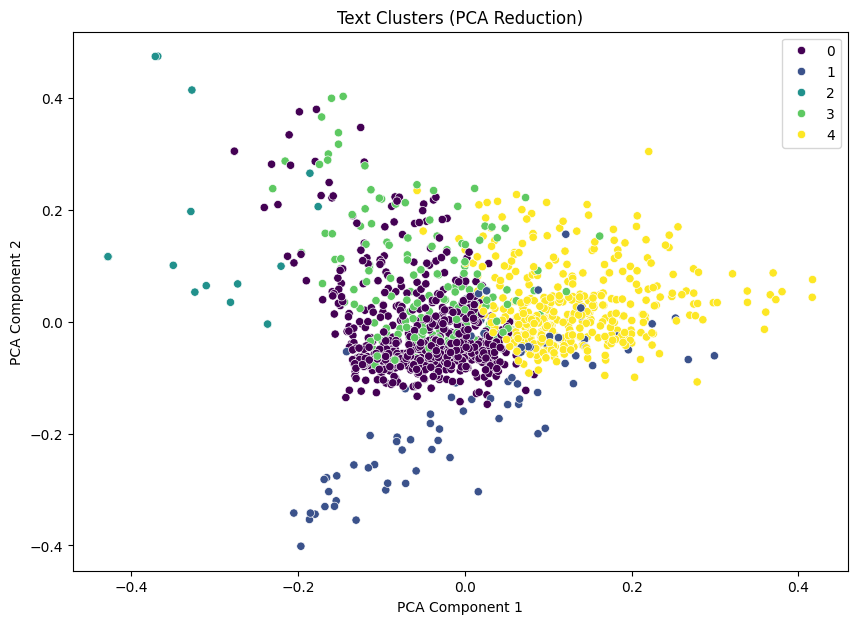

In [ ]:
# =====================
# @title 🚀 Main Function
# =====================
def summarize_youtube_data(video_url, api_key, languages=['id', 'en'], max_comments=300, chunk_size=500, num_clusters=5):
    """
    Fetches YouTube comments and transcript, preprocesses them,
    summarizes them using an LLM, clusters comments, and analyzes sentiment.

    Args:
        video_url (str): The URL of the YouTube video.
        api_key (str): Your Google API key.
        languages (list): Preferred languages for transcript.
        max_comments (int): Maximum number of comments to fetch.
        chunk_size (int): Size of text chunks for LLM processing.
        num_clusters (int): Number of clusters for comment analysis.
    """
    # Extract video ID from URL
    video_id_match = re.search(r'(?<=v=)[a-zA-Z0-9_-]+', video_url)
    if not video_id_match:
        print("Invalid YouTube URL.")
        return

    video_id = video_id_match.group(0)
    print(f"Processing video ID: {video_id}")

    fetcher = YouTubeDataFetcher()
    preprocessor = TextPreprocessor()
    llm_handler = ReplicateLLMHandler()
    sentiment_analyzer = SentimentAnalyzer(llm_handler)
    vectorizer = Vectorizer()
    clusterer = TextClusterer(n_clusters=num_clusters)

    # 1. Fetch Data
    best_lang = fetcher.detect_best_language(video_id, preferred_order=languages)
    transcript_text = ""
    if best_lang:
        transcript = fetcher.get_youtube_transcript(video_id, languages=[best_lang])
        if transcript:
            transcript_text = " ".join([item['text'] for item in transcript])
            print(f"Fetched transcript in {best_lang}.")
        else:
            print("Failed to fetch transcript.")
    else:
        print("No suitable transcript found.")


    comments = fetcher.get_youtube_comments(video_id, api_key, max_comments)
    if not comments:
        print("Failed to fetch comments.")
        comments = [] # Ensure comments is an empty list if fetching fails

    print(f"Fetched {len(comments)} comments.")

    # 2. Preprocess Data
    preprocessed_transcript = preprocessor.preprocess_text(transcript_text, language=best_lang if best_lang else 'english')
    comment_texts = [comment['text'] for comment in comments]

    # Use ThreadPoolExecutor for faster comment preprocessing
    preprocessed_comments = []
    with ThreadPoolExecutor(max_workers=5) as executor:
        # Determine comment language - simple approach: assume English if transcript isn't available
        comment_lang = best_lang if best_lang else 'english'
        results = executor.map(lambda text: preprocessor.preprocess_text(text, language=comment_lang), comment_texts)
        preprocessed_comments = list(results)

    # Remove empty strings after preprocessing
    preprocessed_comments = [comment for comment in preprocessed_comments if comment.strip()]

    print(f"Preprocessing complete. {len(preprocessed_comments)} comments remain after cleaning.")

    # Combine transcript and comments for overall summary (optional)
    all_text = preprocessed_transcript + " " + " ".join(preprocessed_comments)

    # 3. Summarize using LLM (using all text or just comments)
    print("Generating summary and sentiment analysis...")

    if not all_text.strip():
        print("No text available to summarize.")
        summary_html = beautify_output("<h2>Summary</h2><p>No content to summarize.</p>")
        sentiment_html = beautify_output("<h2>Sentiment Analysis</h2><p>No content to analyze.</p>")
    else:
        # Chunk text for LLM processing if it's too long
        text_chunks = list(chunk_text(all_text, chunk_size=chunk_size))

        # Summarize each chunk (can be parallelized if needed)
        chunk_summaries = []
        for i, chunk in enumerate(text_chunks):
            print(f"Processing chunk {i+1}/{len(text_chunks)}...")
            try:
                chunk_summary_prompt = topic_extraction_prompt + chunk
                chunk_summary = llm_handler.invoke_model(chunk_summary_prompt)
                chunk_summaries.append(chunk_summary)
                # print(f"Chunk {i+1} summary: {chunk_summary[:200]}...") # Debug print
            except Exception as e:
                 print(f"Error summarizing chunk {i+1}: {e}")
                 chunk_summaries.append("")

        # Combine chunk summaries for overall summary/topics
        overall_topics = " ".join(chunk_summaries)

        # Generate overall summary based on overall_topics and format as HTML
        if overall_topics.strip():
            summary_html = beautify_output(f"<h2>Summary</h2><p>{overall_topics}</p>")
        else:
            summary_html = beautify_output("<h2>Summary</h2><p>Could not generate a summary from the text.</p>")


        # Perform sentiment analysis on the combined topics and potentially the relevant text
        # For simplicity, we'll analyze sentiment based on the overall topics derived
        # A more advanced approach would involve analyzing sentiment per comment or based on the full text
        try:
            sentiment_analysis_result = sentiment_analyzer.analyze(
                text=" ".join(preprocessed_comments), # Analyze sentiment based on preprocessed comments
                topic_prompt=topic_extraction_prompt, # Use topic extraction prompt for initial topic identification by analyzer
                sentiment_prompt=sentiment_analysis_prompt_template
            )
            sentiment_html = beautify_output(sentiment_analysis_result)
            print("Sentiment analysis complete.")
        except Exception as e:
            print(f"Error during sentiment analysis: {e}")
            sentiment_html = beautify_output("<h2>Sentiment Analysis</h2><p>Error performing sentiment analysis.</p>")


    # 4. Cluster Comments (using preprocessed comments)
    print("Clustering comments...")
    comment_texts_for_clustering = [comment['text'] for comment in comments if preprocessor.preprocess_text(comment['text'], language=best_lang if best_lang else 'english').strip()]

    if comment_texts_for_clustering:
        try:
            vectorized_comments = vectorizer.fit_transform(comment_texts_for_clustering)
            comment_labels = clusterer.fit_predict(vectorized_comments)

            print(f"Clustering complete. Found {num_clusters} clusters.")

            # Optionally visualize clusters
            try:
                 clusterer.visualize_clusters(vectorized_comments, comment_labels)
            except Exception as e:
                 print(f"Error visualizing clusters: {e}")


            # Display example comments from each cluster
            cluster_summary_html = "<h2>Comment Clusters</h2>"
            for i in range(num_clusters):
                cluster_indices = [j for j, label in enumerate(comment_labels) if label == i]
                if cluster_indices:
                    cluster_summary_html += f"<h3>Cluster {i+1} ({len(cluster_indices)} comments)</h3>"
                    # Get indices relative to original comments list
                    original_indices = [idx for idx, preprocessed_comment in enumerate([preprocessor.preprocess_text(c['text'], language=best_lang if best_lang else 'english') for c in comments]) if preprocessed_comment.strip() and preprocessed_comment.strip() in comment_texts_for_clustering][cluster_indices[0]:cluster_indices[0]+3] # Show first 3 from original list

                    cluster_summary_html += "<ul>"
                    for original_idx in original_indices:
                         if original_idx < len(comments):
                            cluster_summary_html += f"<li>... {comments[original_idx]['text'][:150]} ...</li>" # Show snippet of original comment
                    cluster_summary_html += "</ul>"
                else:
                     cluster_summary_html += f"<h3>Cluster {i+1} (0 comments)</h3><p>No comments in this cluster.</p>"

            cluster_html = beautify_output(cluster_summary_html)

        except Exception as e:
            print(f"Error during comment clustering: {e}")
            cluster_html = beautify_output("<h2>Comment Clusters</h2><p>Error performing comment clustering.</p>")

    else:
         print("Not enough valid comments for clustering.")
         cluster_html = beautify_output("<h2>Comment Clusters</h2><p>Not enough valid comments for clustering.</p>")


    # 5. Display Results
    display(HTML(summary_html)) # Display summary HTML
    display(HTML(sentiment_html))
    display(HTML(cluster_html))


# =====================
# @title ▶️ Run Analysis
# =====================

# @markdown Enter the YouTube video URL and your Google API Key
youtube_video_url = "https://www.youtube.com/watch?v=0OXaanDHENI" #@param {type:"string"}
google_api_key = userdata.get('YOUTUBE_API_KEY') # @param {type:"string"}

# @markdown Advanced Settings
preferred_languages = "id,en" # @param {type:"string"}
max_comments_to_fetch = 3000 # @param {type:"number"}
llm_chunk_size = 500 # @param {type:"number"}
number_of_comment_clusters = 5 # @param {type:"number"}

# Split preferred languages string into a list
preferred_languages_list = [lang.strip() for lang in preferred_languages.split(',') if lang.strip()]

if not youtube_video_url or youtube_video_url == "https://www.youtube.com/watch?v=example_video_id":
    print("Please enter a valid YouTube video URL.")
elif not google_api_key:
     print("Please set your Google API Key in Colab Secrets (key name: google_api_key).")
else:
    summarize_youtube_data(
        youtube_video_url,
        google_api_key,
        languages=preferred_languages_list,
        max_comments=max_comments_to_fetch,
        chunk_size=llm_chunk_size,
        num_clusters=number_of_comment_clusters
    )

### This is successfull Sentiment Analysis Summary:
The text provided is a collection of diverse comments, discussions, and reflections on CRISPR gene-editing technology. The sentiments expressed are a mix of excitement, apprehension, and concern, reflecting the complex nature of this technology.

1. **Positive Sentiments**: - CRISPR's potential to cure diseases (sickle cell anemia, genetic disorders). - Enhancement of human capabilities (strength, intelligence, longevity). - Applications in agriculture for better nutrition, drought tolerance, and increased yield. - Hope for treating conditions like cancer, Parkinson's, and genetic disorders. - Praise for Cleo Abram's interview skills and the quality of the content.
2. **Neutral Sentiments**: - Acknowledgment of CRISPR's revolutionary nature. - Discussion on the technology's dual-purpose potential in both beneficial and harmful applications.
3. **Negative Sentiments**: - Deep concerns about ethical implications, including eugenics, genetic discrimination, and the creation of a genetic divide. - Fear of unintended consequences and misuse for military or nefarious purposes. - Calls for robust regulation and international cooperation to ensure responsible development and application. - Worries about economic and social impact, such as exacerbating inequalities and altering societal norms. - Apprehension regarding future scenarios, including designer babies and the modification of entire species.
4. **Mixed Sentiments**: - Excitement mixed with apprehension about future possibilities, such as enhanced soldiers and potential changes to human identity. - Recognition of both the benefits and risks associated with gene editing technologies.

### Actionable Insights:
1. **Regulation and Ethical Oversight**: - Emphasize the need for stringent regulation and ethical oversight to prevent misuse by governments or corporations. - Advocate for international cooperation to ensure responsible development and application of CRISPR technology.
2. **Education and Public Engagement**: - Promote public education about CRISPR

Processing video ID: oX7OduG1YmI


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Language detection error oX7OduG1YmI: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=oX7OduG1YmI! This is most likely caused by:

YouTube is blocking requests from your IP. This usually is due to one of the following reasons:
- You have done too many requests and your IP has been blocked by YouTube
- You are doing requests from an IP belonging to a cloud provider (like AWS, Google Cloud Platform, Azure, etc.). Unfortunately, most IPs from cloud providers are blocked by YouTube.

There are two things you can do to work around this:
1. Use proxies to hide your IP address, as explained in the "Working around IP bans" section of the README (https://github.com/jdepoix/youtube-transcript-api?tab=readme-ov-file#working-around-ip-bans-requestblocked-or-ipblocked-exception).
2. (NOT RECOMMENDED) If you authenticate your requests using cookies, you will be able to continue doing requests for a while. However, YouTube will eventually permanently ban the account tha

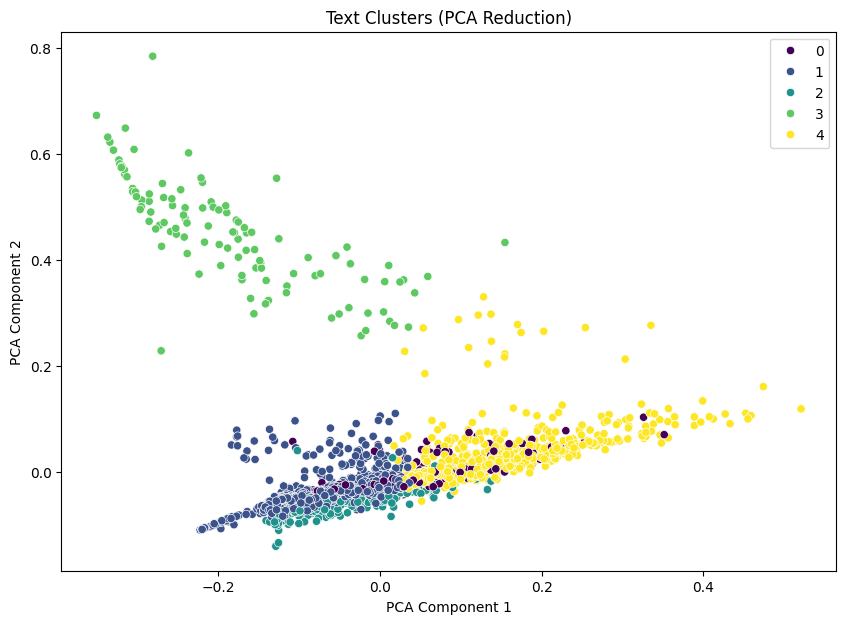

In [ ]:
# prompt: create youtube comments sumarizer

# =====================
# @title 🚀 Main Function
# =====================
def summarize_youtube_data(video_url, api_key, languages=['id', 'en'], max_comments=300, chunk_size=500, num_clusters=5):
    """
    Fetches YouTube comments and transcript, preprocesses them,
    summarizes them using an LLM, clusters comments, and analyzes sentiment.

    Args:
        video_url (str): The URL of the YouTube video.
        api_key (str): Your Google API key.
        languages (list): Preferred languages for transcript.
        max_comments (int): Maximum number of comments to fetch.
        chunk_size (int): Size of text chunks for LLM processing.
        num_clusters (int): Number of clusters for comment analysis.
    """
    # Extract video ID from URL
    video_id_match = re.search(r'(?<=v=)[a-zA-Z0-9_-]+', video_url)
    if not video_id_match:
        print("Invalid YouTube URL.")
        return

    video_id = video_id_match.group(0)
    print(f"Processing video ID: {video_id}")

    fetcher = YouTubeDataFetcher()
    preprocessor = TextPreprocessor()
    llm_handler = ReplicateLLMHandler()
    sentiment_analyzer = SentimentAnalyzer(llm_handler)
    vectorizer = Vectorizer()
    clusterer = TextClusterer(n_clusters=num_clusters)

    # 1. Fetch Data
    best_lang = fetcher.detect_best_language(video_id, preferred_order=languages)
    transcript_text = ""
    if best_lang:
        transcript = fetcher.get_youtube_transcript(video_id, languages=[best_lang])
        if transcript:
            transcript_text = " ".join([item['text'] for item in transcript])
            print(f"Fetched transcript in {best_lang}.")
        else:
            print("Failed to fetch transcript.")
    else:
        print("No suitable transcript found.")


    comments = fetcher.get_youtube_comments(video_id, api_key, max_comments)
    if not comments:
        print("Failed to fetch comments.")
        comments = [] # Ensure comments is an empty list if fetching fails

    print(f"Fetched {len(comments)} comments.")

    # 2. Preprocess Data
    preprocessed_transcript = preprocessor.preprocess_text(transcript_text, language=best_lang if best_lang else 'english')
    comment_texts = [comment['text'] for comment in comments]

    # Use ThreadPoolExecutor for faster comment preprocessing
    preprocessed_comments = []
    with ThreadPoolExecutor(max_workers=5) as executor:
        # Determine comment language - simple approach: assume English if transcript isn't available
        comment_lang = best_lang if best_lang else 'english'
        results = executor.map(lambda text: preprocessor.preprocess_text(text, language=comment_lang), comment_texts)
        preprocessed_comments = list(results)

    # Remove empty strings after preprocessing
    preprocessed_comments = [comment for comment in preprocessed_comments if comment.strip()]

    print(f"Preprocessing complete. {len(preprocessed_comments)} comments remain after cleaning.")

    # Combine transcript and comments for overall summary (optional)
    all_text = preprocessed_transcript + " " + " ".join(preprocessed_comments)

    # 3. Summarize using LLM (using all text or just comments)
    print("Generating summary and sentiment analysis...")

    if not all_text.strip():
        print("No text available to summarize.")
        summary_html = beautify_output("<h2>Summary</h2><p>No content to summarize.</p>")
        sentiment_html = beautify_output("<h2>Sentiment Analysis</h2><p>No content to analyze.</p>")
    else:
        # Chunk text for LLM processing if it's too long
        text_chunks = list(chunk_text(all_text, chunk_size=chunk_size))

        # Summarize each chunk (can be parallelized if needed)
        chunk_summaries = []
        for i, chunk in enumerate(text_chunks):
            print(f"Processing chunk {i+1}/{len(text_chunks)}...")
            try:
                chunk_summary_prompt = topic_extraction_prompt + chunk
                chunk_summary = llm_handler.invoke_model(chunk_summary_prompt)
                chunk_summaries.append(chunk_summary)
                # print(f"Chunk {i+1} summary: {chunk_summary[:200]}...") # Debug print
            except Exception as e:
                 print(f"Error summarizing chunk {i+1}: {e}")
                 chunk_summaries.append("")

        # Combine chunk summaries for overall summary/topics
        overall_topics = " ".join(chunk_summaries)

        # Generate overall summary based on overall_topics and format as HTML
        if overall_topics.strip():
            summary_html = beautify_output(f"<h2>Summary</h2><p>{overall_topics}</p>")
        else:
            summary_html = beautify_output("<h2>Summary</h2><p>Could not generate a summary from the text.</p>")


        # Perform sentiment analysis on the combined topics and potentially the relevant text
        # For simplicity, we'll analyze sentiment based on the overall topics derived
        # A more advanced approach would involve analyzing sentiment per comment or based on the full text
        try:
            sentiment_analysis_result = sentiment_analyzer.analyze(
                text=" ".join(preprocessed_comments), # Analyze sentiment based on preprocessed comments
                topic_prompt=topic_extraction_prompt, # Use topic extraction prompt for initial topic identification by analyzer
                sentiment_prompt=sentiment_analysis_prompt_template
            )
            sentiment_html = beautify_output(sentiment_analysis_result)
            print("Sentiment analysis complete.")
        except Exception as e:
            print(f"Error during sentiment analysis: {e}")
            sentiment_html = beautify_output("<h2>Sentiment Analysis</h2><p>Error performing sentiment analysis.</p>")


    # 4. Cluster Comments (using preprocessed comments)
    print("Clustering comments...")
    comment_texts_for_clustering = [comment['text'] for comment in comments if preprocessor.preprocess_text(comment['text'], language=best_lang if best_lang else 'english').strip()]

    if comment_texts_for_clustering:
        try:
            vectorized_comments = vectorizer.fit_transform(comment_texts_for_clustering)
            comment_labels = clusterer.fit_predict(vectorized_comments)

            print(f"Clustering complete. Found {num_clusters} clusters.")

            # Optionally visualize clusters
            try:
                 clusterer.visualize_clusters(vectorized_comments, comment_labels)
            except Exception as e:
                 print(f"Error visualizing clusters: {e}")


            # Display example comments from each cluster
            cluster_summary_html = "<h2>Comment Clusters</h2>"
            for i in range(num_clusters):
                cluster_indices = [j for j, label in enumerate(comment_labels) if label == i]
                if cluster_indices:
                    cluster_summary_html += f"<h3>Cluster {i+1} ({len(cluster_indices)} comments)</h3>"
                    # Get indices relative to original comments list
                    original_indices = [idx for idx, preprocessed_comment in enumerate([preprocessor.preprocess_text(c['text'], language=best_lang if best_lang else 'english') for c in comments]) if preprocessed_comment.strip() and preprocessed_comment.strip() in comment_texts_for_clustering][cluster_indices[0]:cluster_indices[0]+3] # Show first 3 from original list

                    cluster_summary_html += "<ul>"
                    for original_idx in original_indices:
                         if original_idx < len(comments):
                            cluster_summary_html += f"<li>... {comments[original_idx]['text'][:150]} ...</li>" # Show snippet of original comment
                    cluster_summary_html += "</ul>"
                else:
                     cluster_summary_html += f"<h3>Cluster {i+1} (0 comments)</h3><p>No comments in this cluster.</p>"

            cluster_html = beautify_output(cluster_summary_html)

        except Exception as e:
            print(f"Error during comment clustering: {e}")
            cluster_html = beautify_output("<h2>Comment Clusters</h2><p>Error performing comment clustering.</p>")

    else:
         print("Not enough valid comments for clustering.")
         cluster_html = beautify_output("<h2>Comment Clusters</h2><p>Not enough valid comments for clustering.</p>")


    # 5. Display Results
    display(HTML(summary_html)) # Display summary HTML
    display(HTML(sentiment_html))
    display(HTML(cluster_html))


# =====================
# @title ▶️ Run Analysis
# =====================

# @markdown Enter the YouTube video URL and your Google API Key
youtube_video_url = "https://www.youtube.com/watch?v=oX7OduG1YmI" #@param {type:"string"}
google_api_key = userdata.get('YOUTUBE_API_KEY') # @param {type:"string"}

# @markdown Advanced Settings
preferred_languages = "id,en" # @param {type:"string"}
max_comments_to_fetch = 3000 # @param {type:"number"}
llm_chunk_size = 500 # @param {type:"number"}
number_of_comment_clusters = 5 # @param {type:"number"}

# Split preferred languages string into a list
preferred_languages_list = [lang.strip() for lang in preferred_languages.split(',') if lang.strip()]

if not youtube_video_url or youtube_video_url == "https://www.youtube.com/watch?v=example_video_id":
    print("Please enter a valid YouTube video URL.")
elif not google_api_key:
     print("Please set your Google API Key in Colab Secrets (key name: google_api_key).")
else:
    summarize_youtube_data(
        youtube_video_url,
        google_api_key,
        languages=preferred_languages_list,
        max_comments=max_comments_to_fetch,
        chunk_size=llm_chunk_size,
        num_clusters=number_of_comment_clusters
    )

###This is unsuccessfull Sentiment Analysis Summary:
This text is a transcript of a lengthy and complex conversation or interview, possibly between Cleo Abram and Mark Zuckerberg, discussing various topics including augmented reality (AR) glasses, artificial intelligence (AI), the impact of social media on human interaction and privacy, and the potential future of technology. It appears to be a detailed account of a discussion that touches on the implications of emerging technologies on society, human relationships, and ethical considerations. The text includes various opinions, questions, and comments, suggesting it's a record of a thought-provoking dialogue. As an AI, I can't directly interpret or experience emotions, but the text implies a mix of optimism about technological advancements and skepticism about their societal implications. It raises concerns about privacy, the erosion of human connection due to technology, and the potential misuse of AI and AR. The conversation also hints at the role of tech leaders like Zuckerberg, Elon Musk, and Jeff Bezos in shaping the future. The text ends without a clear resolution or conclusion, leaving the discussion open-ended, much like real-life dialogues that often continue beyond the recorded snippet. It's written in a casual, conversational style, with interjections and informal language typical of such exchanges.